# [파이썬 머신러닝 완벽 가이드] <br>
# 05 회귀

## 05-4 사이킷런 LinearRegression을 이용한 보스턴 주택 가격 예측 <br>

### [LinearRegression 클래스 - Ordinary Least Squares]
- 예측값과 실제값의 RSS(Residual Sum of Squares)를 최소화해 OLS(Ordinary Least Squares) 추정 방식으로 구현한 클래스
- `fit()` 메소드로 X, y 배열을 입력 받으면 회귀 계수(Coefficients)인 W를 coef_ 속성에 저장함

`class sklearn.linear_model.LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=1)`
<br>
- 입력 파라미터
    - `fit_intercept': Boolean 값으로, default는 True임. intercept(절편) 값을 계산할 것인지 말지를 지정함. 만일 False로 지정하면 intercept가 사용되지 않고 0으로 지정됨.
    - `normalize`: Boolean 값으로, default는 False임. fit_intercept가 False인 경우에는 이 파라미터가 무시됨. 만일 True이면 회귀를 수행하기 전에 입력 데이터 세트를 정규화함.
- 속성
    - `coef_`: fit() 메소드를 수행했을 때 회귀 계수가 배열 형태로 저장하는 속성. Shape는 (Target 값 개수, 피처 개수).
    - `intercept_`: intercept 값 <br><br>
- Ordinary Least Squares 기반의 회귀 계수 계산은 입력 피처의 독립성에 많은 영향을 받음
- 피처 간의 상관관계가 매우 높은 경우 분산이 매우 커져서 오류에 매우 민감해지는데 이러한 현상을 다중 공선성 (multi-collinearity) 문제라고 함
- 일반적으로 상관관계가 높은 피처가 많은 경우 독립적인 중요한 피처만 남기고 제거하거나 규제를 적용함
- 매우 많은 피처가 다중 공선성 문제를 가지고 있다면 PCA를 통해 차원 축소를 수행하는 것도 고려해 볼 수 있음

### [회귀 평가 지표]
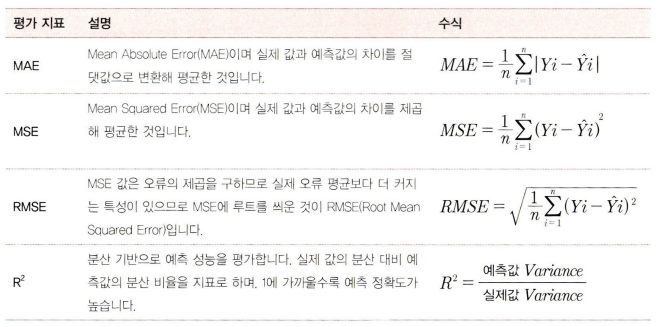 <br>
- 이 밖에 MSE나 RMSE에 로그를 적용한 MSLE(Mean Squared Log Error)와 RMSLE(Root Mean Squared Log Error)도 사용함 <br><br>

- 각 평가 방법에 대한 사이킷런의 API 및 cross_val_score나 GridSearchCV에서 평가 시 사용되는 scoring 파라미터의 적용 값 <br>
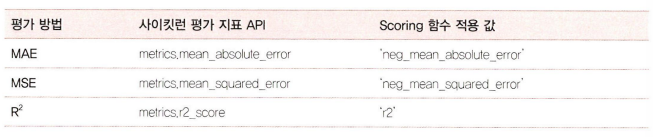 <br><br>
- `cross_val_score`, `GridSearchCV`와 같은 Scoring 함수에 회귀 평가 지표를 적용할 때 한 가지 유의할 점
- MAE의 scoring 파라미터 값을 보면 `neg_mean_absolute_error`와 같이 'neg_'가 붙어있으며 이는 Negative(음수) 값을 가진다는 의미인데 MAE는 절댓값의 합이기 때문에 음수가 될 수 없음
- Scoring 함수에 `neg_mean_absolute_error`를 적용해 음수값을 반환하는 이유는 사이킷런의 Scoring 함수가 score 값이 클수록 좋은 평가 결과로 자동 평가하기 때문임 (특히 GridSearchCV의 경우 가장 좋은 Evaluation 값을 가지는 하이퍼 파라미터로 Estimator를 학습까지 자동으로 시킬 수 있음)
- 실제값과 예측값의 오류 차이를 기반으로 하는 회귀 평가 지표의 경우 값이 커지면 오히려 나쁜 모델이라는 의미이므로 이를 사이킷런의 Scoring 함수에 일반적으로 반영하려면 보정이 필요함
- 따라서 -1을 원래의 평가 지표 값에 곱해서 음수를 만들어 작은 오류 값이 더 큰 숫자로 인식하게 함

### [LinearRegression을 이용해 보스턴 주택 가격 회귀 구현]
- `CRIM`: 지역별 범죄 발생률
- `ZN`: 25000평방피트를 초과하는 거주 지역의 비율
- `INDUS`: 비상업 지역 넓이 비율
- `CHAS`: 찰스강에 대한 더미 변수 (강의 경계에 위치한 경우는 1, 아니면 0)
- `NOX`: 일산화질소 농도
- `RM`: 거주할 수 있는 방 개수
- `AGE`: 1940년 이전에 건축된 소유 주택의 비율
- `DIS`: 5개 주요 고용센터까지의 가중 거리
- `RAD`: 고속도로 접근 용이도
- `TAX`: 10000달러당 재산세율
- `PTRATIO`: 지역의 교사와 학생 수 비율
- `B`: 지역의 흑인 거주 비율
- `LSTAT`: 하위 계층의 비율
- `MEDV`: 본인 소유의 주택 가격 (중앙값)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.datasets import load_boston

#boston 데이터 세트 로드
boston = load_boston()

#boston 데이터 세트 DataFrame 반환
bostonDF = pd.DataFrame(boston.data, columns=boston.feature_names)

#boston 데이터 세트의 target 배열은 주택 가격임. 이를 PRICE 칼럼으로 DataFrame에 추가함
bostonDF['PRICE'] = boston.target
print('Boston 데이터 세트 크기:', bostonDF.shape)
bostonDF.head()

Boston 데이터 세트 크기: (506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [3]:
bostonDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  PRICE    506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


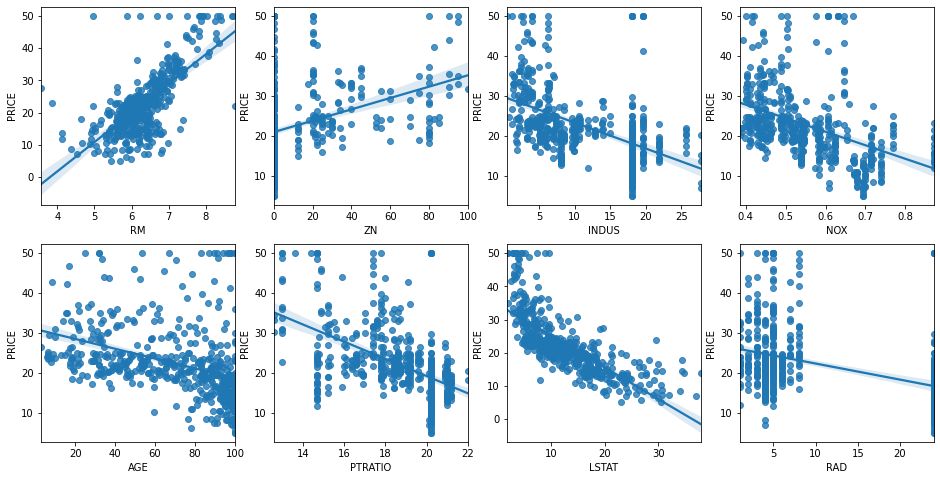

In [4]:
#2개의 행과 4개의 열을 가진 subplots를 이용. axs는 4x2개의 ax를 가짐
fig, axs = plt.subplots(figsize=(16,8), ncols=4, nrows=2)
lm_features = ['RM','ZN','INDUS','NOX','AGE','PTRATIO','LSTAT','RAD']
for i, feature in enumerate(lm_features):
    row = int(i/4)
    col = i%4
    
    #seaborn의 regplot을 이용해 산점도와 선형 회귀 직선을 함께 표현
    sns.regplot(x=feature, y='PRICE', data=bostonDF, ax=axs[row][col])

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'], axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size=0.3, random_state=156)

#선형 회귀 OLS로 학습/예측/평가 수행
lr = LinearRegression()
lr.fit(X_train, y_train)
y_preds = lr.predict(X_test)
mse = mean_squared_error(y_test, y_preds)
rmse = np.sqrt(mse)

print('MSE: {0:.3f}, RMSE: {1:.3f}'.format(mse, rmse))
print('Variance score: {0:.3f}'.format(r2_score(y_test, y_preds)))

MSE: 17.297, RMSE: 4.159
Variance score: 0.757


In [6]:
print('절편 값:',lr.intercept_)
print('회귀 계수값:',np.round(lr.coef_,1))

절편 값: 40.995595172164336
회귀 계수값: [ -0.1   0.1   0.    3.  -19.8   3.4   0.   -1.7   0.4  -0.   -0.9   0.
  -0.6]


In [7]:
#회귀 계수를 큰 값 순으로 정렬하기 위해 Series로 생성. 인덱스 칼럼명에 유의
coeff = pd.Series(data=np.round(lr.coef_,1), index=X_data.columns)
coeff.sort_values(ascending=False)

RM          3.4
CHAS        3.0
RAD         0.4
ZN          0.1
B           0.0
TAX        -0.0
AGE         0.0
INDUS       0.0
CRIM       -0.1
LSTAT      -0.6
PTRATIO    -0.9
DIS        -1.7
NOX       -19.8
dtype: float64

In [8]:
from sklearn.model_selection import cross_val_score

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'], axis=1, inplace=False)
lr = LinearRegression()

#cross_val_score()로 5 폴드 세트로 MSE를 구한 뒤 이를 기반으로 다시 RMSE 구함
neg_mse_scores = cross_val_score(lr, X_data, y_target, scoring='neg_mean_squared_error', cv=5)
rmse_scores = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

#cross_val_score(scoring='neg_mean_squared_error')로 반환된 값은 모두 음수
print('5 folds의 개별 Negative MSE scores:', np.round(neg_mse_scores, 2))
print('5 folds의 개별 RMSE scores:', np.round(rmse_scores,2))
print('5 folds의 평균 RMSE: {0:.3f}'.format(avg_rmse))

5 folds의 개별 Negative MSE scores: [-12.46 -26.05 -33.07 -80.76 -33.31]
5 folds의 개별 RMSE scores: [3.53 5.1  5.75 8.99 5.77]
5 folds의 평균 RMSE: 5.829
